In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from scipy.optimize import linear_sum_assignment

# STEP 3 -  Learning for joint social influence and matching
Consider the case in which the company can observe the type of each customer Ci.
Moreover, assume that both the edge activation probabilities and reward distributions F(Dj,
Ci) are unknown. Apply jointly the greedy algorithm (for influence maximization) and the
matching algorithm using upper confidence bound in place of the edge activation
probabilities and the expected reward of each match. Apply jointly the greedy algorithm (for
influence maximization) and the matching algorithm using the TS algorithm to estimate the
edge activation probabilities and the expected reward of each match. Report the plots of the
average value and standard deviation of the cumulative regret, cumulative reward,
instantaneous regret, and instantaneous reward.

In [2]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [3]:
class Learner:
    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, [reward])
        self.t += 1

In [4]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)
    
    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)
        
    def expectations(self):
        return self.empirical_means

In [5]:
class TSLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)  # Initialize the means array with zeros

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1]))
        return idx
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)

    def expectations(self):
        return self.means


In [6]:
def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

In [7]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def get_reward(node_class, product_class, rewards_parameters):
    return 100-np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])


def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 3, 25, 10)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]

        while units != [0, 0, 0]:

            for customer in class_activation_flow:

                # find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)

In [8]:
class UCBMatching(UCBLearner):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        assert n_arms == n_rows * n_cols

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        upper_conf[np.isinf(upper_conf)] = 1e3
        row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
        return (row_ind, col_ind)
    
    def update(self, pulled_arms, reward):
        self.t+=1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        for pulled_arm, reward in zip(pulled_arms_flat, reward):
            self.update_observations(pulled_arm, reward)
            self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t - 1) + reward) / self.t
            

    def expectations(self):
        return self.empirical_means

In [9]:
class TSMatching(TSLearner):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)
    
    def pull_arm(self):
        samples = np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1])
        row_ind, col_ind = linear_sum_assignment(-samples.reshape(3, 3))
        return row_ind, col_ind
    
    def update(self, pulled_arms, reward):
        self.t+=1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
        
        for pulled_arm, reward in zip(pulled_arms_flat, reward):
            self.update_observations(pulled_arm, reward)
            self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
            self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)
                
    def expectations(self):
        return self.means

## Estimating Edge Activation Probabilities

In [114]:
n_arms = 30
edge_rate=0.03
graph_structure = np.random.binomial(1, edge_rate, (n_arms, n_arms))
graph_probabilities = np.random.uniform(0.1, 0.9, (n_arms, n_arms)) * graph_structure
graph_probabilities

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.28240962, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

### UCB Learner

In [115]:
def UCB_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=100):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ucb_env = Environment(probabilities=p)
        # Initialize learner
        ucb_learner = UCBLearner(n_arms)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = ucb_learner.pull_arm()
            reward = ucb_env.round(pulled_arm)
            ucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round


import numpy as np

UCB_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = UCB_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    UCB_estimated_graph_probabilities.append(arm_probabilities)

UCB_estimated_graph_probabilities = np.array(UCB_estimated_graph_probabilities)
UCB_estimated_graph_probabilities = np.transpose(UCB_estimated_graph_probabilities, (1, 0, 2))


for table in UCB_estimated_graph_probabilities:
    table = table*graph_structure

Estimating Arm 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.83it/s]


Estimating Arm 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.93it/s]


Estimating Arm 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.55it/s]


Estimating Arm 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.18it/s]


Estimating Arm 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Estimating Arm 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.97it/s]


Estimating Arm 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.53it/s]


Estimating Arm 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.42it/s]


Estimating Arm 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.17it/s]


Estimating Arm 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.59it/s]


Estimating Arm 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.80it/s]


Estimating Arm 11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.14it/s]


Estimating Arm 12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.14it/s]


Estimating Arm 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.52it/s]


Estimating Arm 14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.20it/s]


Estimating Arm 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.05it/s]


Estimating Arm 16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.65it/s]


Estimating Arm 17


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.14it/s]


Estimating Arm 18


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.70it/s]


Estimating Arm 19


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.09it/s]


Estimating Arm 20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.69it/s]


Estimating Arm 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.41it/s]


Estimating Arm 22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.31it/s]


Estimating Arm 23


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


Estimating Arm 24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.30it/s]


Estimating Arm 25


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.06it/s]


Estimating Arm 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.99it/s]


Estimating Arm 27


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.83it/s]


Estimating Arm 28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


Estimating Arm 29


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.47it/s]


### TS Learner

In [116]:
def TS_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=100):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ts_env = Environment(probabilities=p)
        # Initialize learner
        ts_learner = TSLearner(n_arms)

        for t in range(0, T):
            # TS-UCB Learner
            pulled_arm = ts_learner.pull_arm()
            reward = ts_env.round(pulled_arm)
            ts_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ts_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

import numpy as np

TS_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = TS_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    TS_estimated_graph_probabilities.append(arm_probabilities)

TS_estimated_graph_probabilities = np.array(TS_estimated_graph_probabilities)
TS_estimated_graph_probabilities = np.transpose(TS_estimated_graph_probabilities, (1, 0, 2))


    
new_TS_estimated_graph_probabilities = []
for table in TS_estimated_graph_probabilities:
    cleaned_table = table*graph_structure
    new_TS_estimated_graph_probabilities.append(cleaned_table)

TS_estimated_graph_probabilities = new_TS_estimated_graph_probabilities

Estimating Arm 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.78it/s]


Estimating Arm 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.79it/s]


Estimating Arm 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.88it/s]


Estimating Arm 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.82it/s]


Estimating Arm 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.04it/s]


Estimating Arm 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.56it/s]


Estimating Arm 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.41it/s]


Estimating Arm 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.85it/s]


Estimating Arm 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.90it/s]


Estimating Arm 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.09it/s]


Estimating Arm 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.13it/s]


Estimating Arm 11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.79it/s]


Estimating Arm 12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.68it/s]


Estimating Arm 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.22it/s]


Estimating Arm 14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s]


Estimating Arm 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.03it/s]


Estimating Arm 16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Estimating Arm 17


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.51it/s]


Estimating Arm 18


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.94it/s]


Estimating Arm 19


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]


Estimating Arm 20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


Estimating Arm 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.75it/s]


Estimating Arm 22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.87it/s]


Estimating Arm 23


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.38it/s]


Estimating Arm 24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.92it/s]


Estimating Arm 25


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.44it/s]


Estimating Arm 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.26it/s]


Estimating Arm 27


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.39it/s]


Estimating Arm 28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.26it/s]


Estimating Arm 29


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.12it/s]


## Estimating Matching Reward 

In [117]:
node_classes = 3
product_classes = 3
products_per_class = 3
T = 365

means = np.random.uniform(0.2, 0.8, size=(3,3))
std_dev = np.random.uniform(0.1, 0.2, size=(3, 3))
true_reward_parameters = (means, std_dev)
customer_assignments = np.random.choice([0,1,2], size=30)

### Estimating expected matching reward with UCB

In [118]:
p = true_reward_parameters[0]
n_experiments = 1
T= 365

learner = UCBMatching(p.size, *p.shape)
rewards_per_experiment = []
means_per_experiment = []
env = Environment(p)

means = []
for exp in tqdm(range(n_experiments)):
    experiment_means = []

    for t in range(T):
        pulled_arms = learner.pull_arm()
        reward = env.round(pulled_arms)
        learner.update(pulled_arms, reward)
        x = learner.expectations()
        experiment_means.append(np.array(x).reshape(3,3))
        
    means.append(experiment_means)

means = np.array(means)
ucb_means = np.mean(means, axis=0)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


### Estimating expected matching reward with TS

In [119]:
p = true_reward_parameters[0]
n_experiments = 1

learner = TSMatching(p.size, *p.shape)
rewards_per_experiment = []
means_per_experiment = []
env = Environment(p)

means = []
for exp in tqdm(range(n_experiments)):
    experiment_means = []

    for t in range(T):
        pulled_arms = learner.pull_arm()
        reward = env.round(pulled_arms)
        learner.update(pulled_arms, reward)
        x = learner.expectations()
        experiment_means.append(np.array(x).reshape(3,3))
        
    means.append(experiment_means)

means = np.array(means)
ts_means = np.mean(means, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.70it/s]


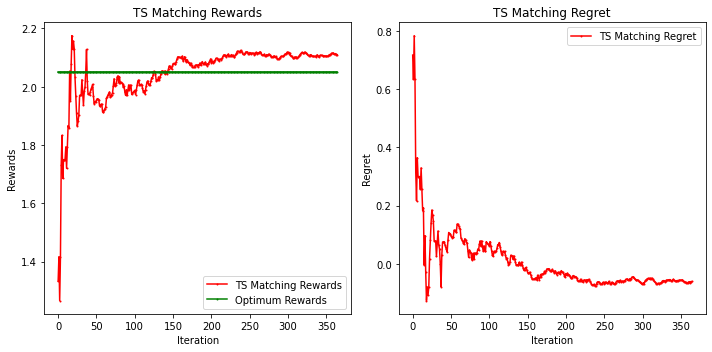

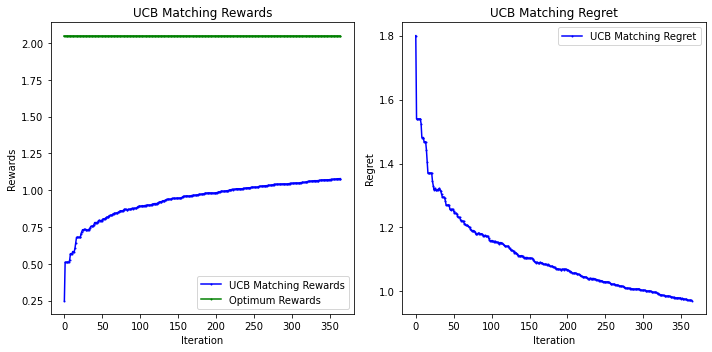

In [120]:
# to remove

row_ind, col_ind = linear_sum_assignment(-p)
optimum = p[row_ind, col_ind].sum()


ucb_matching_rewards = []
ucb_matching_regret = []

for i in range(len(ucb_means)):
    matrix = ucb_means[i]
    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching_rewards_sum = matrix[row_ind, col_ind].sum()
    ucb_matching_rewards.append(matching_rewards_sum)
    ucb_matching_regret.append(optimum - matching_rewards_sum)
    

ts_matching_rewards = []
ts_matching_regret = []

for i in range(len(ts_means)):
    matrix = ts_means[i]
    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching_rewards_sum = matrix[row_ind, col_ind].sum()
    ts_matching_rewards.append(matching_rewards_sum)
    ts_matching_regret.append(optimum - matching_rewards_sum)
    

    
optimums = []
for i in range(len(ucb_means)):
    optimums.append(optimum)
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ts_matching_rewards, marker='o', markersize=1,label='TS Matching Rewards', color="red")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('TS Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ts_matching_regret, marker='o',markersize=1, color='red', label='TS Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('TS Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ucb_matching_rewards, marker='o', markersize=1,label='UCB Matching Rewards', color = "blue")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('UCB Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ucb_matching_regret, marker='o', markersize=1, color='blue', label='UCB Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('UCB Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()


## Estimating overall reward

In [121]:
std_dev = np.full(9, 0.05)
std_dev = std_dev.reshape(3,3)

import random 
T = 365
avg_ucb_overall_rew = []
avg_ts_overall_rew = []
std_dev_ucb_overall_rew = []
std_dev_ts_overall_rew = []



for index in range(T):
    
    ucb_round_score = clairvoyant(UCB_estimated_graph_probabilities[index], graph_probabilities, customer_assignments, (ucb_means[index],std_dev), true_reward_parameters, n_exp=10)
    avg_ucb_overall_rew.append(ucb_round_score[0])
    std_dev_ucb_overall_rew.append(ucb_round_score[1])
    
    
    ts_round_score = clairvoyant(TS_estimated_graph_probabilities[index], graph_probabilities, customer_assignments,(ts_means[index],std_dev), true_reward_parameters, n_exp=10)
    avg_ts_overall_rew.append(ts_round_score[0])
    std_dev_ts_overall_rew.append(ucb_round_score[1])


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.13it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1431.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.94it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 908.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 907.90it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 998.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.83it/s]


In [133]:
optimum_means = []
optimum_std_dev = []
attempts = []

for x in range(100):
    z = clairvoyant(graph_probabilities, graph_probabilities, customer_assignments, true_reward_parameters, true_reward_parameters, n_exp=1000)
    attempts.append(z[0])

clairvoyant_output=max(attempts)


for t in range(T):
    optimum_means.append(clairvoyant_output)
    #optimum_std_dev.append(clairvoyant_output[1])


(896.1876814429685, 0.5581617569796411)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3501.33it/s]


(896.1584604642524, 0.5570183307263449)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3445.02it/s]


(896.1788374653955, 0.5376018559468688)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3484.82it/s]


(896.1857437735332, 0.5338124620630571)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3628.03it/s]


(896.1629918445403, 0.5592979797441954)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3862.06it/s]


(896.1712740003269, 0.5688920066619052)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3575.20it/s]


(895.6599220884765, 0.5658072044161372)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3822.89it/s]


(895.6761510037247, 0.5378711448677588)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3780.24it/s]


(895.663405340284, 0.5380043581442716)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3585.44it/s]


(896.1563821319756, 0.5690053323454177)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3513.85it/s]


(896.1611102808614, 0.559675232038645)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3576.21it/s]


(896.1821805216912, 0.5589476218300979)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3780.29it/s]


(895.6986428074539, 0.5628868142939251)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3823.28it/s]


(895.6687262037273, 0.5828395469205222)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3502.29it/s]


(896.1871518468093, 0.5478582124289881)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3576.94it/s]


(895.6741850183967, 0.5311759220006252)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3603.42it/s]


(896.174050182322, 0.5630849500000863)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3664.52it/s]


(895.7371504018321, 0.5561033382078855)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3594.24it/s]


(895.6584878025441, 0.5696077578279013)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3760.77it/s]


(895.6559665270568, 0.5539694004872086)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3441.99it/s]


(896.155488673425, 0.5559699011223092)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3563.86it/s]


(896.1910629211917, 0.5559336887968621)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2660.66it/s]


(895.6659387201671, 0.5539008313770161)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3643.33it/s]


(895.679492782704, 0.5480995375716063)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2570.91it/s]


(896.1537567638559, 0.5419207466296343)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2036.93it/s]


(896.1762900109286, 0.5330268016350798)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2074.87it/s]


(896.1720610975158, 0.5470694190260041)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2139.51it/s]


(896.1653329472081, 0.562059022474887)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2014.09it/s]


(895.6622778420821, 0.5575106543003395)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1998.94it/s]


(896.138188243088, 0.5727804957067857)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2028.92it/s]


(896.1493155536323, 0.5371022674728408)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1938.84it/s]


(896.1814136020269, 0.5656682678452689)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2292.45it/s]


(895.7029396664602, 0.5206058364999231)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1920.94it/s]


(896.1678077255312, 0.5403361142260503)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2062.88it/s]


(896.1711044597267, 0.5618200512722229)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2207.79it/s]


(896.1460973836978, 0.5574439902630552)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2063.87it/s]


(896.0477512964594, 0.5401169414375089)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2064.85it/s]


(896.1623086306214, 0.5552522023621548)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2131.71it/s]


(896.1915058660946, 0.5433115183707803)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1796.20it/s]


(895.7334291470439, 0.545917331588943)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1881.78it/s]


(896.1801572390008, 0.550584520499296)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2063.90it/s]


(896.1849871987582, 0.550132818174223)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2063.89it/s]


(895.6514532170463, 0.5467397372715812)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1999.41it/s]


(896.1540243764356, 0.5446169456286569)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2064.69it/s]


(896.1998943255983, 0.5365155663940873)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2369.66it/s]


(895.6446337995628, 0.5554453691348329)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2112.43it/s]


(896.1629296292786, 0.5698769997124941)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2088.21it/s]


(896.1582414453546, 0.5434899460600415)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2131.55it/s]


(896.1668062086779, 0.5605745515641335)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2125.02it/s]


(896.179751044553, 0.5668779685212184)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1999.38it/s]


(896.1622911975605, 0.5640912612784388)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2131.69it/s]


(896.156809698408, 0.5660453976781544)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2121.39it/s]


(896.1924585549764, 0.5534700814302169)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2132.70it/s]


(896.1551041112436, 0.552251199956729)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2275.25it/s]


(896.1806228335107, 0.5555454203456887)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2045.03it/s]


(896.1705279605675, 0.5420361834889962)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2204.89it/s]


(896.1813125770749, 0.5476701925748592)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2132.68it/s]


(896.1768781116702, 0.5709006198931659)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2286.32it/s]


(896.1918645427521, 0.5290782296178297)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1878.96it/s]


(895.6650415182315, 0.5429766673827972)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2063.86it/s]


(896.1730891232102, 0.5631778085379394)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2213.07it/s]


(896.1640177422396, 0.5682114999364872)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2001.07it/s]


(895.6813864737529, 0.5816372779129422)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2064.86it/s]


(896.172765030715, 0.5362797119313201)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2052.98it/s]


(895.6814483803195, 0.5563988698689671)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2285.02it/s]


(896.1378922652235, 0.5560166525137824)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2132.66it/s]


(896.1577451992823, 0.5653377265462208)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2138.77it/s]


(896.1706596928444, 0.551459515682084)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2165.04it/s]


(896.1791035945088, 0.5505973697851227)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1999.38it/s]


(895.6447717954189, 0.5301529240854533)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1827.61it/s]


(896.1578380380139, 0.5507752831299909)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2068.63it/s]


(896.1742297437025, 0.5571510724396775)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1729.20it/s]


(895.7093360791916, 0.5497537790442255)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1720.76it/s]


(896.1688112774963, 0.5547901768672605)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1447.64it/s]


(896.166071537122, 0.5589711283586289)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1882.52it/s]


(896.1466088878789, 0.5548526577553482)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2132.68it/s]


(896.1556087108773, 0.565273199850712)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1987.97it/s]


(895.6932542983526, 0.5215793457560863)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1938.79it/s]


(896.1703544209234, 0.5540046865074452)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2132.69it/s]


(896.1383703279845, 0.5622747204803029)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2063.87it/s]


(896.1698575345271, 0.5396825546114616)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2285.03it/s]


(896.1981459105341, 0.5623993597019704)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2051.53it/s]


(896.1573780046895, 0.5529726589295653)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2221.17it/s]


(895.6607907026082, 0.5560833420989781)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1828.02it/s]


(896.1430578408443, 0.5675549715042572)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1777.24it/s]


(896.1611193469292, 0.5454172376633831)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1881.78it/s]


(896.1725850727884, 0.5674155035274433)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1828.01it/s]


(895.6251925646103, 0.5603319931376123)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2206.22it/s]


(895.6720415583778, 0.54598838539393)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1729.21it/s]


(896.1653385376658, 0.5572246413274459)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2206.23it/s]


(896.1802822567197, 0.5759819273388838)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1896.54it/s]


(895.6921854169071, 0.5394512026961653)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1591.75it/s]


(895.6438650593728, 0.5383800835115847)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1881.76it/s]


(896.1410964302105, 0.5449044824620819)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2000.20it/s]


(896.1707755172253, 0.5617561418408162)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1683.93it/s]


(896.1635645308766, 0.5510756756033681)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2164.30it/s]


(895.7076397040202, 0.5479156506621241)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1929.52it/s]


(896.1860145517519, 0.54227949603439)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1882.73it/s]


(896.1907277045323, 0.5421961579118016)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1778.14it/s]


(896.1612891270241, 0.548538165051687)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1651.67it/s]

896.1998943255983


In [134]:
optimum_means

[896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,
 896.1998943255983,


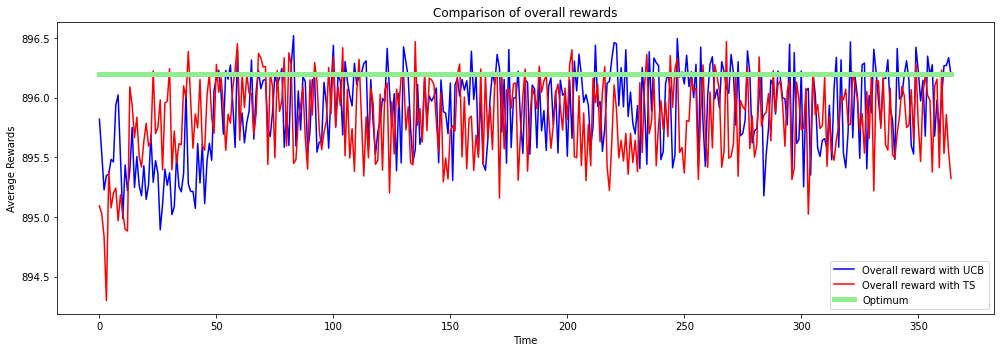

In [135]:
x = np.arange(T)

plt.figure(figsize=(14, 5))  
plt.plot(x, avg_ucb_overall_rew, label='Overall reward with UCB', color="blue")
plt.plot(x, avg_ts_overall_rew, label='Overall reward with TS', color="red")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('Comparison of overall rewards')
plt.legend()



plt.tight_layout()
plt.show()

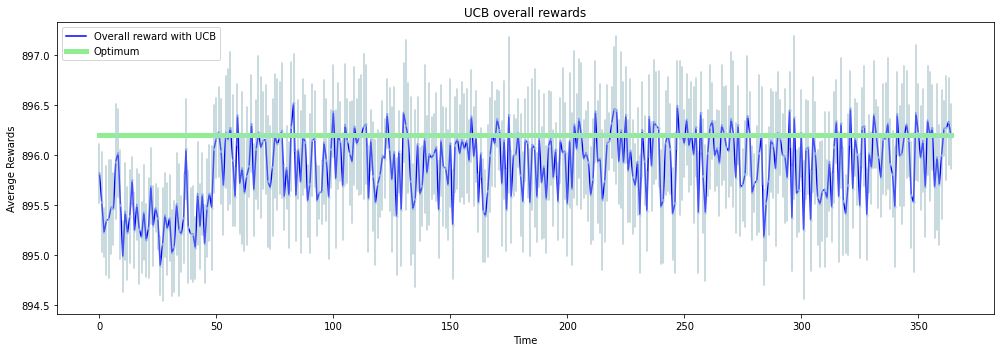

In [140]:

x = np.arange(T)

plt.figure(figsize=(14, 5))

for i in range(len(x)):
    plt.plot([x[i], x[i]], [avg_ucb_overall_rew[i] - std_dev_ucb_overall_rew[i], avg_ucb_overall_rew[i] + std_dev_ucb_overall_rew[i]], color='lightgrey')

plt.plot(x, avg_ucb_overall_rew, label='Overall reward with UCB', color="blue")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

plt.errorbar(x, avg_ucb_overall_rew, yerr=std_dev_ucb_overall_rew, fmt='o', markersize=2, color="lightblue", alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('UCB overall rewards')
plt.legend()

plt.tight_layout()
plt.show()



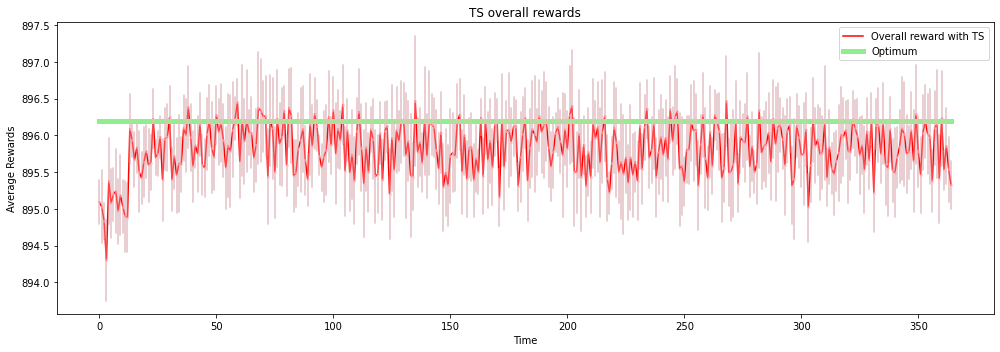

In [141]:
x = np.arange(T)

plt.figure(figsize=(14, 5))

for i in range(len(x)):
    plt.plot([x[i], x[i]], [avg_ts_overall_rew[i] - std_dev_ts_overall_rew[i], avg_ts_overall_rew[i] + std_dev_ts_overall_rew[i]], color='lightgrey')

plt.plot(x, avg_ts_overall_rew, label='Overall reward with TS', color="red")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

plt.errorbar(x, avg_ts_overall_rew, yerr=std_dev_ts_overall_rew, fmt='o', markersize=2, color="lightpink", alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('TS overall rewards')
plt.legend()

plt.tight_layout()
plt.show()

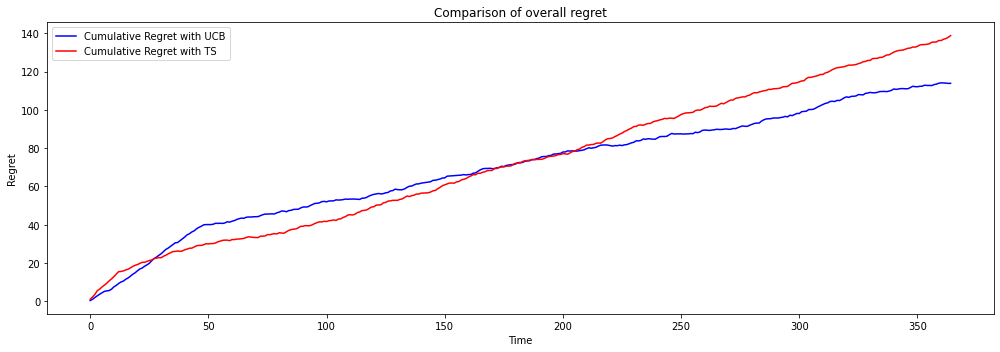

In [138]:
x = np.arange(T)

ucb_regret = np.subtract(optimum_means, avg_ucb_overall_rew)
ts_regret = np.subtract(optimum_means, avg_ts_overall_rew)
cumulative_ucb_regret = np.cumsum(ucb_regret)
cumulative_ts_regret = np.cumsum(ts_regret)


plt.figure(figsize=(14, 5))  
plt.plot(x, cumulative_ucb_regret, label='Cumulative Regret with UCB', color="blue")
plt.plot(x, cumulative_ts_regret, label='Cumulative Regret with TS', color="red")

plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Comparison of overall regret')
plt.legend()



plt.tight_layout()
plt.show()

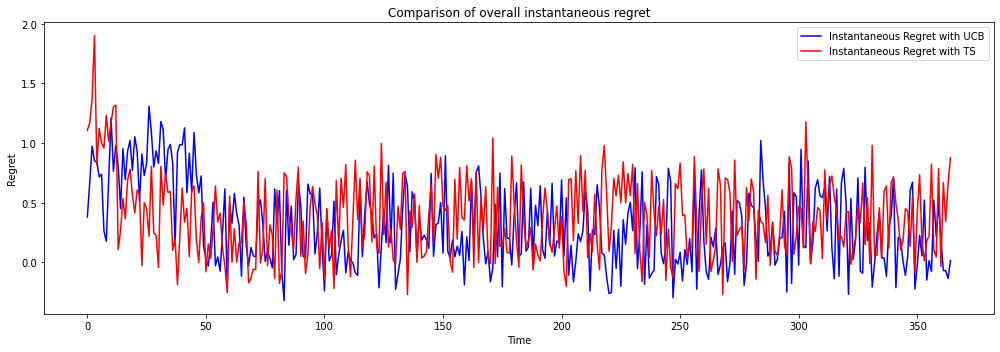

In [139]:
plt.figure(figsize=(14, 5)) 
plt.plot(x, ucb_regret, label='Instantaneous Regret with UCB', color="blue")
plt.plot(x, ts_regret, label='Instantaneous Regret with TS', color="red")

plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Comparison of overall instantaneous regret')
plt.legend()



plt.tight_layout()
plt.show()